In [126]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [127]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=1
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [128]:
m = 3
N_particles = 4 * m**3
spacing = 2.1
K = math.ceil(N_particles ** (1 / 3))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, L, 0, 0, 0]


In [129]:
frame.particles.types = ['A']

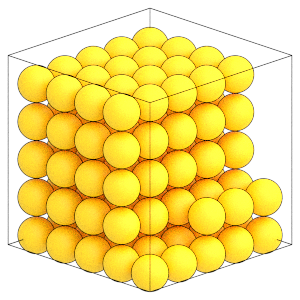

In [130]:
render(frame)

In [131]:
fn = os.path.join(os.getcwd(), 'lattice.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='lattice.gsd', mode='x') as f:
    f.append(frame)

In [132]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='lattice.gsd')

In [133]:
mc = hoomd.hpmc.integrate.Sphere()
mc.shape['A'] = dict(diameter=2)

simulation.operations.integrator = mc

In [134]:
initial_snapshot = simulation.state.get_snapshot

In [135]:
simulation.run(10e3)

In [136]:
mc.translate_moves

(3162198, 1157802)

In [137]:
mc.overlaps

0

In [138]:
mc.rotate_moves

(0, 0)

In [139]:
N_particles

108

In [140]:
mc.type_shapes

[{'type': 'Sphere', 'diameter': 2}]

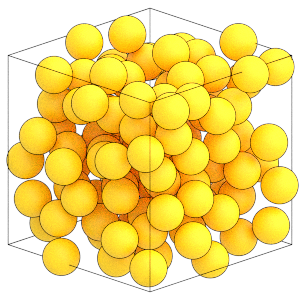

In [141]:
final_snapshot = simulation.state.get_snapshot()
render(final_snapshot)

In [142]:
fn = os.path.join(os.getcwd(), 'random.gsd')
![ -e "$fn" ] && rm "$fn"
hoomd.write.GSD.write(state=simulation.state, mode='xb', filename='random.gsd')